# Label propagation

In [53]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os

In [54]:
test_images = [
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1003.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1004.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1005.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1018.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1019.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1023.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1024.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1025.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1038.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1039.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1101.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1104.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1107.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1110.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1113.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1116.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1119.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1122.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1125.nii.gz",
        "C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/MISSSSSA/Atlas_part2/test-set/testing-images/1128.nii.gz"
    ]

In [ ]:
def load_image(image_path):
    # Load the image using nibabel
    image = nib.load(image_path)
    data = image.get_fdata()
    return data, image.affine

def create_label_image(csf_map, wm_map, gm_map):
    label_image = np.zeros(csf_map.shape, dtype=np.int32)
    label_image[(csf_map > wm_map) & (csf_map > gm_map)] = 1  # CSF
    label_image[(wm_map > csf_map) & (wm_map > gm_map)] = 2   # WM
    label_image[(gm_map > csf_map) & (gm_map > wm_map)] = 3   # GM
    return label_image

def save_label_image(label_image, affine, output_path):
    label_nifti = nib.Nifti1Image(label_image, affine)
    nib.save(label_nifti, output_path)

def dice_score(segmentation, ground_truth, label):
    """
    Calculate Dice score for a specific label.
    
    :param segmentation: Numpy array of the segmented image
    :param ground_truth: Numpy array of the ground truth image
    :param label: Label for the tissue (e.g., 1 for CSF, 2 for GM, 3 for WM)
    :return: Dice score for the specified label
    """
    seg = (segmentation == label)
    gt = (ground_truth == label)
    
    intersection = np.sum(seg * gt)
    total = np.sum(seg) + np.sum(gt)
    
    if total == 0:
        # To handle cases where both segmentations do not contain this label
        return 1.0 if intersection == 0 else 0.0
    
    dice = (2. * intersection) / total
    return dice

def compute_dice_scores(segmentation_path, ground_truth_path):
    """
    Compute Dice scores for each label and the average Dice score.
    
    :param segmentation_path: Path to the segmented NIfTI image
    :param ground_truth_path: Path to the ground truth NIfTI image
    :return: Dictionary with Dice scores for each label and the average Dice score
    """
    # Load images
    segmentation_img = nib.load(segmentation_path)
    ground_truth_img = nib.load(ground_truth_path)
    
    # Convert to numpy arrays
    segmentation = segmentation_img.get_fdata().astype(int)
    ground_truth = ground_truth_img.get_fdata().astype(int)
    
    # Calculate Dice score for each label
    labels = [1, 2, 3]  # Assuming labels are 1, 2, 3 for CSF, GM, WM
    label_val = {1:"CSF", 2:"WM", 3:"GM"}
    dice_scores = {f'Dice_label_{label_val[label]}': dice_score(segmentation, ground_truth, label) for label in labels}
    
    # Calculate average Dice score
    dice_scores['Average_Dice'] = np.mean(list(dice_scores.values()))
    
    return segmentation_img, ground_truth_img, dice_scores

for f in test_images:
    num = f.split("/")[-1].split(".")[0]
    test_image_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\test-set\testing-images\{num}.nii.gz".replace("\\","/")
    csf_prob_map_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\Code\Outputs_MNI\MapsRigid\{num}.nii\CSF_final_transformed_{num}.nii.nii".replace("\\","/")
    wm_prob_map_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\Code\Outputs_MNI\MapsRigid\{num}.nii\WM_final_transformed_{num}.nii.nii".replace("\\","/")
    gm_prob_map_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\Code\Outputs_MNI\MapsRigid\{num}.nii\GM_final_transformed_{num}.nii.nii".replace("\\","/")

    #Load test image
    test_image, affine = load_image(test_image_path)

    #Prob maps
    csf_prob_map, _ = load_image(csf_prob_map_path)
    wm_prob_map, _ = load_image(wm_prob_map_path)
    gm_prob_map, _ = load_image(gm_prob_map_path)

    label_image = create_label_image(csf_prob_map, wm_prob_map, gm_prob_map).astype(np.float32)
    output_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\Code\Label_prop\Label_prop_{num}".replace("\\", "/")
    save_label_image(label_image, affine, output_path)

    segmentation_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\Code\Label_prop\Label_prop_{num}.nii".replace("\\", "/")
    ground_truth_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\test-set\testing-labels\{num}_3C.nii.gz".replace("\\", "/")

    # Compute Dice scores
    segmentation_labels, gt_labels, dice_scores = compute_dice_scores(segmentation_path, ground_truth_path)

    slice_num = 160  # Taking a middle slice
    slice_data_labels = segmentation_labels[:, :, slice_num]
    slice_data_gt = gt_labels[:, :, slice_num]

    # Plot the slice
    plt.figure(figsize=(15, 10))
    plt.subplot(1,2,1)
    plt.imshow(slice_data_labels.T, cmap='jet', origin='lower')
    plt.colorbar()
    plt.title(f'Slice {slice_num} label propagation')

    plt.subplot(1,2,2)
    plt.imshow(slice_data_gt.T, cmap='jet', origin='lower')
    plt.colorbar()
    plt.title(f'Slice {slice_num} GT')
    plt.show()
    # Print Dice scores
    for label, score in dice_scores.items():
        print(f'Patient {num} {label}: {score:.4f}')  
    
    print("\n")

Patient 1003 Dice_label_CSF: 0.4232
Patient 1003 Dice_label_WM: 0.6782
Patient 1003 Dice_label_GM: 0.6048
Patient 1003 Average_Dice: 0.5687


Patient 1004 Dice_label_CSF: 0.5260
Patient 1004 Dice_label_WM: 0.6474
Patient 1004 Dice_label_GM: 0.6269
Patient 1004 Average_Dice: 0.6001


Patient 1005 Dice_label_CSF: 0.3902
Patient 1005 Dice_label_WM: 0.6171
Patient 1005 Dice_label_GM: 0.5784
Patient 1005 Average_Dice: 0.5286


Patient 1018 Dice_label_CSF: 0.6834
Patient 1018 Dice_label_WM: 0.6644
Patient 1018 Dice_label_GM: 0.6041
Patient 1018 Average_Dice: 0.6506


Patient 1019 Dice_label_CSF: 0.3860
Patient 1019 Dice_label_WM: 0.6163
Patient 1019 Dice_label_GM: 0.5800
Patient 1019 Average_Dice: 0.5274


Patient 1023 Dice_label_CSF: 0.4472
Patient 1023 Dice_label_WM: 0.6755
Patient 1023 Dice_label_GM: 0.6002
Patient 1023 Average_Dice: 0.5743


Patient 1024 Dice_label_CSF: 0.5081
Patient 1024 Dice_label_WM: 0.6414
Patient 1024 Dice_label_GM: 0.6476
Patient 1024 Average_Dice: 0.5990


Patien

In [56]:
print(csf_prob_map.shape)
print(wm_prob_map.shape)
print(gm_prob_map.shape)
print(type(csf_prob_map))

(256, 316, 256)
(256, 316, 256)
(256, 316, 256)
<class 'numpy.memmap'>


# Skull stripping, not used, really, but good to remember

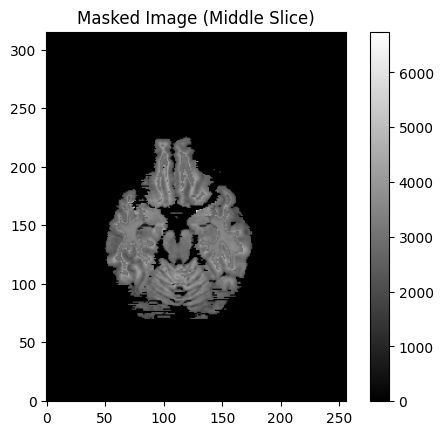

In [ ]:
image_path = r"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\test-set\testing-images\1003.nii.gz".replace("\\","/")
mask_path = r"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\test-set\testing-labels\1003_3C.nii.gz".replace("\\", "/")

image = nib.load(image_path)
mask = nib.load(mask_path)

image_data = image.get_fdata()
mask_data = mask.get_fdata()

masked_image_data = image_data * mask_data

test_image, affine = load_image(test_image_path)

slice_num = masked_image_data.shape[2] // 2
plt.imshow(masked_image_data[:, :, slice_num].T, cmap='gray', origin='lower')
plt.colorbar()
plt.title("Masked Image (Middle Slice)")
plt.show()

# Visualization

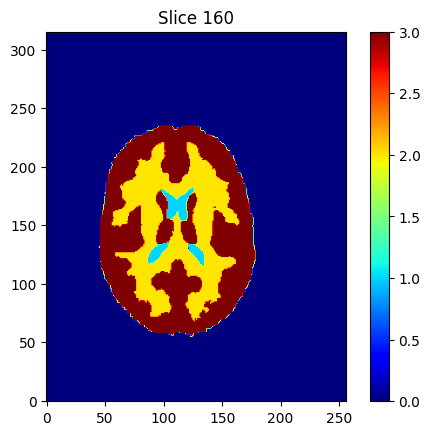

In [51]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI file
file_path = r"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\Code\Label_prop\label_prop_prueba.nii".replace("\\", "/")  # Replace with your file path
img = nib.load(file_path)

# Get the image data as a NumPy array
data = img.get_fdata()

# Select a slice to display (e.g., middle slice along the third axis)
slice_num = 160  # Taking a middle slice
slice_data = data[:, :, slice_num]

# Plot the slice
plt.imshow(slice_data.T, cmap='jet', origin='lower')
plt.colorbar()
plt.title(f'Slice {slice_num}')
plt.show()

# Calculate Dice score

In [58]:
def dice_score(segmentation, ground_truth, label):
    """
    Calculate Dice score for a specific label.
    
    :param segmentation: Numpy array of the segmented image
    :param ground_truth: Numpy array of the ground truth image
    :param label: Label for the tissue (e.g., 1 for CSF, 2 for GM, 3 for WM)
    :return: Dice score for the specified label
    """
    seg = (segmentation == label)
    gt = (ground_truth == label)
    
    intersection = np.sum(seg * gt)
    total = np.sum(seg) + np.sum(gt)
    
    if total == 0:
        # To handle cases where both segmentations do not contain this label
        return 1.0 if intersection == 0 else 0.0
    
    dice = (2. * intersection) / total
    return dice

def compute_dice_scores(segmentation_path, ground_truth_path):
    """
    Compute Dice scores for each label and the average Dice score.
    
    :param segmentation_path: Path to the segmented NIfTI image
    :param ground_truth_path: Path to the ground truth NIfTI image
    :return: Dictionary with Dice scores for each label and the average Dice score
    """
    # Load images
    segmentation_img = nib.load(segmentation_path)
    ground_truth_img = nib.load(ground_truth_path)
    
    # Convert to numpy arrays
    segmentation = segmentation_img.get_fdata().astype(int)
    ground_truth = ground_truth_img.get_fdata().astype(int)
    
    # Calculate Dice score for each label
    labels = [1, 2, 3]  # Assuming labels are 1, 2, 3 for CSF, GM, WM
    dice_scores = {f'Dice_label_{label}': dice_score(segmentation, ground_truth, label) for label in labels}
    
    # Calculate average Dice score
    dice_scores['Average_Dice'] = np.mean(list(dice_scores.values()))
    
    return dice_scores


In [61]:

# Paths to the segmented and ground truth images
patient = 1003
segmentation_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\Code\Label_prop\Label_prop_{patient}.nii".replace("\\", "/")
ground_truth_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\MISSSSSA\Atlas_part2\test-set\testing-labels\1003_3C.nii.gz".replace("\\", "/")

# Compute Dice scores
dice_scores = compute_dice_scores(segmentation_path, ground_truth_path)

# Print Dice scores
for label, score in dice_scores.items():
    print(f'{label}: {score:.4f}')

Dice_label_1: 0.4232
Dice_label_2: 0.6782
Dice_label_3: 0.6048
Average_Dice: 0.5687
